In [1]:
import torch
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

## Q1: How likely is the maximum increase to occur in lower triangle (top-down), and how likely is the maximum decrease to occur in upper triangle (bottom-up)?
Conclusion: top-down processing is possibly more effective at sharpening, while bottom-up processing is possibly more effective at dampening.

In [2]:
import re
from pathlib import Path
from itertools import product

modulators = []
modulator_type = []
modulator_strengths = []

seeds = []
network_names = []

from_layer = []
to_layer = []

from_layer_idx = []
to_layer_idx = []

dampening_score = []
sharpening_score = []

direction = []
hidden_sizes = []

# Parse and load contioning matrices
for record in Path("../outs").glob("*/conditioning_*"):
    # Name indicates the modulator
    modulator = record.name

    # Parent indicates network name and seed
    network_name, hidden_size, seed = record.parent.name.split("_")

    # Load the matrices
    sharpen_scores, dampen_scores, layer_names = torch.load(record)

    # Make a dataframe
    for layer_from, layer_to in product(range(len(layer_names)), repeat=2):
        modulators.append(modulator)
        mod_type, mod_strength = re.split("_|\(|\)", modulator)[1:3]

        modulator_type.append(mod_type)
        modulator_strengths.append(float(mod_strength.split("=")[1]))

        hidden_sizes.append(int(hidden_size))

        seeds.append(seed)
        network_names.append(network_name)

        from_layer.append(layer_names[layer_from])
        to_layer.append(layer_names[layer_to])

        from_layer_idx.append(layer_from)
        to_layer_idx.append(layer_to)

        if layer_from == layer_to:
            direction.append("self")
        elif layer_from < layer_to:
            direction.append("bottom-up")
        elif layer_from > layer_to:
            direction.append("top-down")

        sharpening_score.append(float(sharpen_scores[layer_from, layer_to]))
        dampening_score.append(float(dampen_scores[layer_from, layer_to]))

df_all = pd.DataFrame({
    "modulator": modulators,
    "modulator_type": modulator_type,
    "modulator_strength": modulator_strengths,
    "seed": seeds,
    "network_name": network_names,
    "from_layer": from_layer,
    "to_layer": to_layer,
    "hidden_size": hidden_sizes,
    "from_layer_idx": from_layer_idx,
    "to_layer_idx": to_layer_idx,
    "sharpening_score": sharpening_score,
    "dampening_score": dampening_score,
    "direction": direction
})

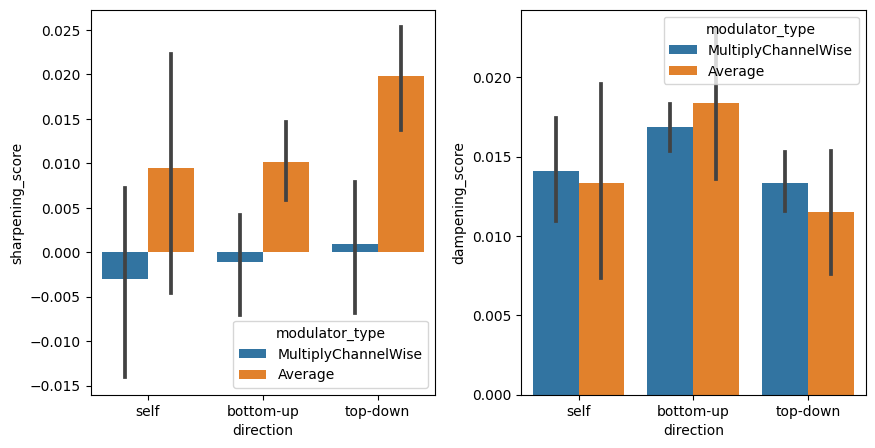

In [18]:
# Filter by model
hidden_size = 64
model = "resnet18"

# Only look at average and multiply channel wise
df = df_all.query("modulator_type in ['Average', 'MultiplyChannelWise']")

# Limit alpha value to 0.5
alpha = 0.6
df = df[(df["modulator_strength"] == alpha)]
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Adjust size
fig.subplots_adjust(wspace=0.25)

# Plot the results as bar plots, two subplots
chart1 = sns.barplot(data=df[(df["network_name"] == model) & (df["hidden_size"] == hidden_size)], x="direction", y="sharpening_score", hue="modulator_type", ax=axes[0])
chart2 = sns.barplot(data=df[(df["network_name"] == model) & (df["hidden_size"] == hidden_size)], x="direction", y="dampening_score", hue="modulator_type", ax=axes[1])

## Q2: plot upper, lower triangle mean wrt alpha

<Axes: xlabel='modulator_strength', ylabel='dampening_score'>

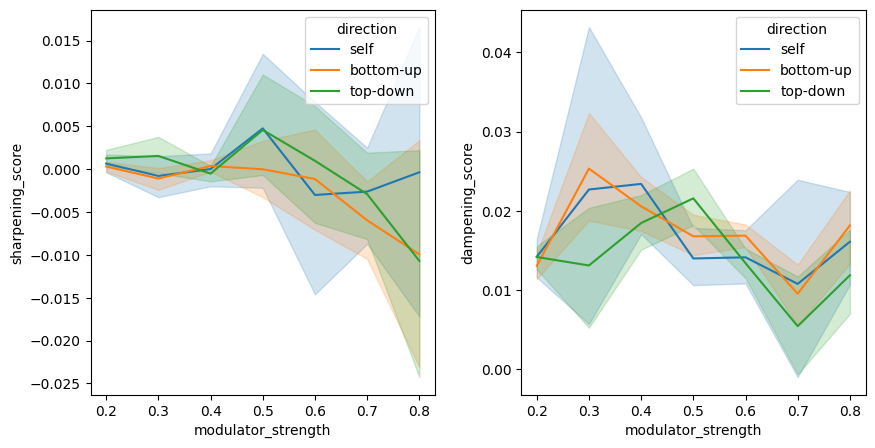

In [16]:
# Filter by model
hidden_size = 64
model = "resnet18"

# Only look at average and multiply channel wise
df = df_all.query("modulator_type in ['MultiplyChannelWise']")

# Plot each score as a line plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Adjust size
fig.subplots_adjust(wspace=0.25)
sns.lineplot(data=df[(df["network_name"] == model) & (df["hidden_size"] == hidden_size)], x="modulator_strength", y="sharpening_score", hue="direction", ax=axes[0])
sns.lineplot(data=df[(df["network_name"] == model) & (df["hidden_size"] == hidden_size)], x="modulator_strength", y="dampening_score", hue="direction", ax=axes[1])